# Gaussian process regression

Gaussian process regression is a powerful, non-parametric Bayesian regression technique, which allows us to make predictions about the behaviour of systems based on previous observations while keeping a handle on how uncertain we are about those predictions. This contrasts to the majority of other methods for regression which exist in the world of statistics, which can only give us a "best estimate" prediction, and don't really tell us anything about how good that prediciton is likely to be.

An example of the sort of naive regression is "least squares" fitting, where a fitting function is chosen by finding the function which makes predictions which deviate least from the observed data; this can be a powerful technique if it's used in the right context. Let's have a quick look at how this might work.

In [1]:
%matplotlib inline

from pymc3 import  *

import numpy as np
import matplotlib.pyplot as plt

/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


As you can probably see from this list of imported libraries, we'll be making use of a package called `pymc3` during this tutorial. `Pymc3` makes a lot of Bayesian inference algorithms very easy to code-up.

We'll start out by generating some data, and then making a linear fit to the data.

In [4]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x

y = true_regression_line #+ np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


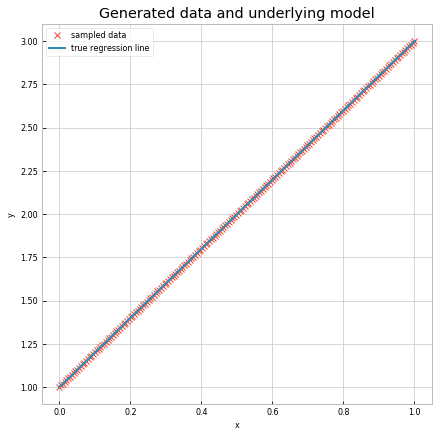

In [5]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

For our very first example, the data have no "noise"; they should fit the model exactly. Let's try coding up a model to fit the data.

Our model should have the form 
\\[ y = mx + c \\]
where $m$ is the gradient (or slope) of the fitting line, and $c$ is the $y$-axis intercept.

In [11]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    intercept = Normal('c', 0, sd=20)
    slope = Normal('m', 0, sd=20)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + slope * x, observed=y)

What's happening here may not be completely clear if you've never encountered something like `pymc3`, `STAN`, or `Winbugs` before. 

We start out by defining _priors_, which are the probability distributions which describe our initial guess about the values for each part of our model. We have two _parameters_ in the model, and each one needs a prior distribution to be attached to it. For the intercept we've said that we expect $c$ will probably lie somewhere around a value of $0$, but we've put a really broad Normal (Gaussian) distribution around $0$, because we're really not sure about where its value lies. The normal notation for this statement would be something like
\\[ c \sim \mathcal{N}(0,20) \\]
that is, $c$ is drawn from a Normal distribution of mean $0$ and variance $20$. 

We also specify that the slope comes from an equally broad distribution, 
\\[ m \sim \mathcal{N}(0,20) \\]

Finally, the statement which really defines the model is the _likelihood_; that's the distribution which gives the probability of the data for a given model. Fitting our model means finding the values of the function parameters which effectively maximise this quantity.

Now that we have an abstract description of our model, we need to find the values of $m$ and $c$ which work best. We could do this by trial-and-error, by putting different values into the function until we find the best one, or we could do something a little faster.

Our first approach is to use an optimisation algorithm to find the set of parameters which gives the highest likelihood. This is called the _maximum a posteriori_ estimate.

In [13]:
with model:
    map_estimate = find_MAP()

logp = -625.29, ||grad|| = 463.25: 100%|██████████| 10/10 [00:00<00:00, 2621.60it/s]


In [15]:
print(map_estimate)

{'m': array(1.99977729), 'c': array(1.00009885)}


These values are *really* close to the values which we used to generate our data (m=2 and c=1), so it's probably time to call it a day, right? You may be a little bit worried though by the fact that they aren't exactly the right numbers, and this is going to become a bigger problem as our data gets harder to interpret.

Let's make a new data set, but this time there's some noise on each measurement.

In [16]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x

y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


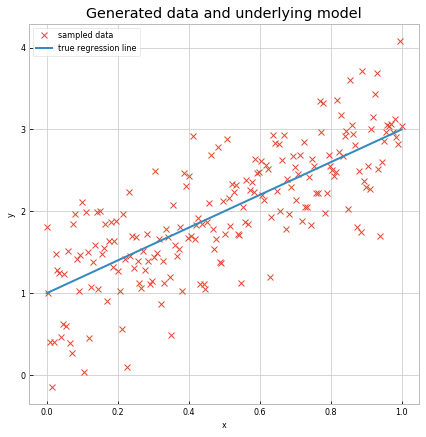

In [17]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

While the data still has a generally linear appearance, it's no longer so clear which line the data should lie along. We clearly need a stategy to cope with this, and it's going to involve testing lots of plausible functions against the data. This time when we specify our model we'll tell it that we believe the $y$-values contain an uncertainty. We can do that by saying that they're drawn from a Normal distribution which has a mean of $mx + c$ and a standard deviation equal to the standard deviation we measure from the data.

In [18]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    intercept = Normal('c', 0, sd=20)
    slope = Normal('m', 0, sd=20)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + slope * x, observed=y, sd=np.std(y))

We'll need to produce lots of likelihood functions, which means performing lots of draws from our prior distributions. There are algorithms called _stochastic samplers_ which are designed to do this; I'm not going to delve too deeply into what these do just now, but they're designed to test lots of variants of the fitting function against the data in the way we need. `pymc3` wraps-up its default sampler in a function called `sample`.

In [19]:
with model:
    # Inference!
    trace = sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, c]
100%|██████████| 3500/3500 [00:02<00:00, 1171.98it/s]
The acceptance probability does not match the target. It is 0.8819000912127549, but should be close to 0.8. Try to increase the number of tuning steps.


The resulting pile of data which we get from the sampler is called a *trace*; we normally cut the first hundred or so values from this off, and don't include them in the rest of the analysis. We call them a *burn-in*, as they're the samples taken while the algorithm was jumping around values fairly haphazardly before identifying a good sampling strategy.

Because we drew a lot of samples we end up with a distribution of parameter values, rather than single values. These are the *posterior distributions* on these parameters. Let's have a look at how our model fitted-up.

/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 504x504 with 0 Axes>

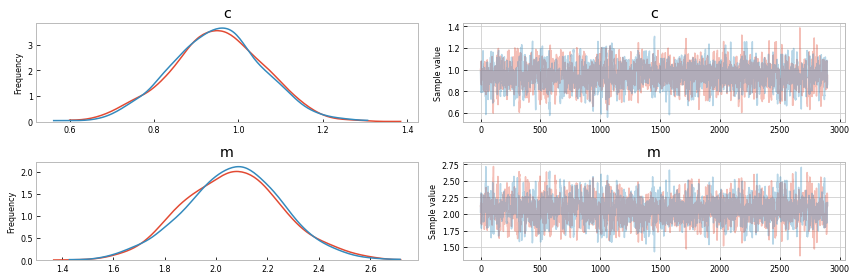

In [20]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

Pleasingly, the "true" values are well within the distributions which we've inferred. The maximum of the distributions lie a little distance away from the true value, but given the amount of noise in the data, we shouldn't be too surprised by that.

We now have multiple functions which might fit the data. Let's have a look at them.

/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


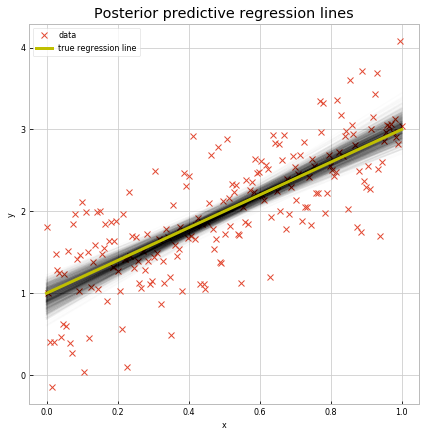

In [28]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')

for i in range(1000):
    f = trace['m'][i] * x + trace['c'][i]
    plt.plot(x, f, color='k', alpha=0.01)
    
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')



plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

The inferred functions all sit fairly close together, but rather than having one single function to describe the data, we now have a whole distribution 